## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##  Data Inspection

Data Collection

In [2]:
df = pd.read_csv('../data/used_car_price_dataset_extended.csv')

In [3]:
df.head()

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,color,service_history,accidents_reported,insurance_valid
0,2001,8.17,4000,Petrol,4,8587.64,Chevrolet,Manual,White,NaN,0,No
1,2014,17.59,1500,Petrol,4,5943.50,Honda,Manual,Black,NaN,0,Yes
2,2023,18.09,2500,Diesel,5,9273.58,BMW,Automatic,Black,Full,1,Yes
3,2009,11.28,800,Petrol,1,6836.24,Hyundai,Manual,Blue,Full,0,Yes
4,2005,12.23,1000,Petrol,2,4625.79,Nissan,Automatic,Red,Full,0,Yes


Check the data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make_year           10000 non-null  int64  
 1   mileage_kmpl        10000 non-null  float64
 2   engine_cc           10000 non-null  int64  
 3   fuel_type           10000 non-null  object 
 4   owner_count         10000 non-null  int64  
 5   price_usd           10000 non-null  float64
 6   brand               10000 non-null  object 
 7   transmission        10000 non-null  object 
 8   color               10000 non-null  object 
 9   service_history     7962 non-null   object 
 10  accidents_reported  10000 non-null  int64  
 11  insurance_valid     10000 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 937.6+ KB


In [5]:
df.shape

(10000, 12)

Check for Missing Values & Duplicates

In [6]:
missing_values = df.isnull().sum()
missing_values

make_year                0
mileage_kmpl             0
engine_cc                0
fuel_type                0
owner_count              0
price_usd                0
brand                    0
transmission             0
color                    0
service_history       2038
accidents_reported       0
insurance_valid          0
dtype: int64

In [7]:
duplicate_count = df.duplicated().sum()
duplicate_count

0

Summary statistics

In [8]:
# Numerical features
df.describe()

,make_year,mileage_kmpl,engine_cc,owner_count,price_usd,accidents_reported
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2009.206900,17.960753,2287.130000,3.003500,7179.754532,0.492200
std,8.373858,5.025486,1291.276927,1.418904,2795.270940,0.694109
min,1995.000000,5.000000,800.000000,1.000000,1000.000000,0.000000
25%,2002.000000,14.540000,1200.000000,2.000000,5176.547500,0.000000
50%,2009.000000,17.970000,1800.000000,3.000000,6961.260000,0.000000
75%,2016.000000,21.352500,3000.000000,4.000000,8993.732500,1.000000
max,2023.000000,35.000000,5000.000000,5.000000,17647.630000,5.000000


In [4]:
# Categorical features
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    print(f"\n{col} - Unique values: {df[col].nunique()}")
    print(df[col].value_counts().head())


fuel_type - Unique values: 3
fuel_type
Petrol      4968
Diesel      4058
Electric     974
Name: count, dtype: int64

brand - Unique values: 10
brand
Nissan        1089
Volkswagen    1033
BMW           1021
Tesla         1006
Honda         1003
Name: count, dtype: int64

transmission - Unique values: 2
transmission
Manual       5985
Automatic    4015
Name: count, dtype: int64

color - Unique values: 6
color
Gray     1705
Black    1702
Red      1678
White    1651
Blue     1634
Name: count, dtype: int64

service_history - Unique values: 2
service_history
Full       4987
Partial    2975
Name: count, dtype: int64

insurance_valid - Unique values: 2
insurance_valid
Yes    7934
No     2066
Name: count, dtype: int64


In [5]:
print(df.head())

   make_year  mileage_kmpl  engine_cc fuel_type  owner_count  price_usd  \
0       2001          8.17       4000    Petrol            4    8587.64   
1       2014         17.59       1500    Petrol            4    5943.50   
2       2023         18.09       2500    Diesel            5    9273.58   
3       2009         11.28        800    Petrol            1    6836.24   
4       2005         12.23       1000    Petrol            2    4625.79   

       brand transmission  color service_history  accidents_reported  \
0  Chevrolet       Manual  White             NaN                   0   
1      Honda       Manual  Black             NaN                   0   
2        BMW    Automatic  Black            Full                   1   
3    Hyundai       Manual   Blue            Full                   0   
4     Nissan    Automatic    Red            Full                   0   

  insurance_valid  
0              No  
1             Yes  
2             Yes  
3             Yes  
4             Ye

## Data Cleaning

In [6]:
df_clean = df.copy()

# Replace "None" strings with NaN
df_clean = df_clean.replace('None', np.nan)

In [7]:
print(df_clean['service_history'].value_counts(dropna=False))

service_history
Full       4987
Partial    2975
NaN        2038
Name: count, dtype: int64


In [11]:
df_clean['insurance_valid']

0        No
1       Yes
2       Yes
3       Yes
4       Yes
       ... 
9995    Yes
9996    Yes
9997    Yes
9998    Yes
9999    Yes
Name: insurance_valid, Length: 10000, dtype: object

In [8]:
# Convert boolean-like columns
df_clean['insurance_valid'] = df_clean['insurance_valid'].map({'Yes': True, 'No': False})
df_clean['insurance_valid']

0       False
1        True
2        True
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998     True
9999     True
Name: insurance_valid, Length: 10000, dtype: bool

In [9]:
# Ensure fields are numeric.
numerical_cols = ['make_year', 'mileage_kmpl', 'engine_cc', 'price_usd', 'owner_count', 'accidents_reported']
for col in numerical_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

In [10]:
# fill with most common value
most_frequent = df_clean['service_history'].mode()[0]

df_clean['service_history'].fillna(most_frequent, inplace=True)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make_year           10000 non-null  int64  
 1   mileage_kmpl        10000 non-null  float64
 2   engine_cc           10000 non-null  int64  
 3   fuel_type           10000 non-null  object 
 4   owner_count         10000 non-null  int64  
 5   price_usd           10000 non-null  float64
 6   brand               10000 non-null  object 
 7   transmission        10000 non-null  object 
 8   color               10000 non-null  object 
 9   service_history     10000 non-null  object 
 10  accidents_reported  10000 non-null  int64  
 11  insurance_valid     10000 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 869.3+ KB


## Feature Engineering

In [12]:
from datetime import datetime
current_year = datetime.now().year
current_year

2025

In [13]:
df_clean['car_age'] = current_year - df_clean['make_year']
df_clean['car_age']

0       24
1       11
2        2
3       16
4       20
        ..
9995    29
9996    28
9997    23
9998    20
9999    18
Name: car_age, Length: 10000, dtype: int64

In [14]:
df_clean['owner_count']

0       4
1       4
2       5
3       1
4       2
       ..
9995    2
9996    1
9997    4
9998    5
9999    1
Name: owner_count, Length: 10000, dtype: int64

In [15]:
# Bin owner_count into categories
def categorize_owners(count):
    if count == 1:
        return '1'
    elif count in [2, 3]:
        return '2-3'
    else:
        return '4+'

df_clean['owner_category'] = df_clean['owner_count'].apply(categorize_owners)

Label Encoding

In [16]:
df_clean['transmission'] = df_clean['transmission'].map({'Manual': 0, 'Automatic': 1})
df_clean['insurance_valid'] = df_clean['insurance_valid'].astype(int)  # True/False → 1/0
df_clean['service_history'] = df_clean['service_history'].map({'Full': 1, 'Partial': 0})

One-hot encoding

In [17]:
categorical_cols = ['fuel_type', 'brand', 'color', 'owner_category']
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

## Outlier Detection and Handling

In [18]:
# Define function for IQR outlier detection
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers in numerical columns [continuous]
outlier_columns = ['price_usd', 'mileage_kmpl', 'engine_cc', 'car_age']

for col in outlier_columns:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    print(f"\n{col}:")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
    print(f"  Bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  Range: {df_clean[col].min():.2f} to {df_clean[col].max():.2f}")


price_usd:
  Outliers: 58 (0.58%)
  Bounds: [-549.23, 14719.51]
  Range: 1000.00 to 17647.63

mileage_kmpl:
  Outliers: 36 (0.36%)
  Bounds: [4.32, 31.57]
  Range: 5.00 to 35.00

engine_cc:
  Outliers: 0 (0.00%)
  Bounds: [-1500.00, 5700.00]
  Range: 800.00 to 5000.00

car_age:
  Outliers: 0 (0.00%)
  Bounds: [-12.00, 44.00]
  Range: 2.00 to 30.00


we choose to remove outliers based on IQR method

In [22]:
for col in ['price_usd', 'mileage_kmpl']:
    _, lower, upper = detect_outliers_iqr(df_clean, col)
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

In [23]:
for col in outlier_columns:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    print(f"\n{col}:")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
    print(f"  Bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  Range: {df_clean[col].min():.2f} to {df_clean[col].max():.2f}")


price_usd:
  Outliers: 0 (0.00%)
  Bounds: [-494.52, 14587.58]
  Range: 1000.00 to 14576.06

mileage_kmpl:
  Outliers: 0 (0.00%)
  Bounds: [4.35, 31.47]
  Range: 5.00 to 31.44

engine_cc:
  Outliers: 0 (0.00%)
  Bounds: [-1500.00, 5700.00]
  Range: 800.00 to 5000.00

car_age:
  Outliers: 0 (0.00%)
  Bounds: [-12.00, 44.00]
  Range: 2.00 to 30.00


##  Exploratory Data Analysis (EDA)

### A. Univariate Analysis

Histograms for numerical features

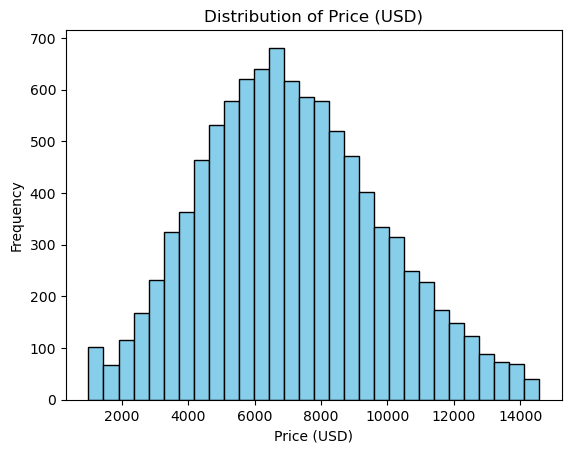

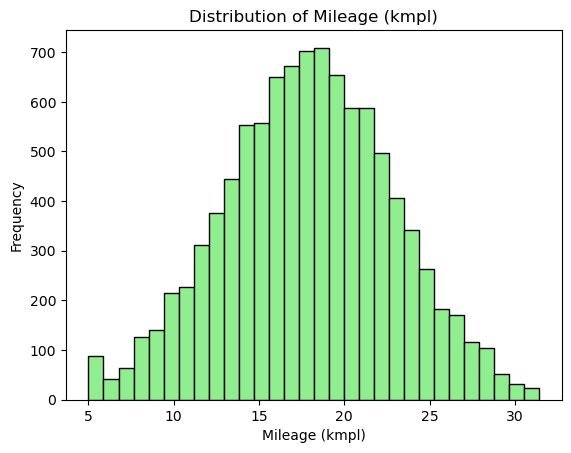

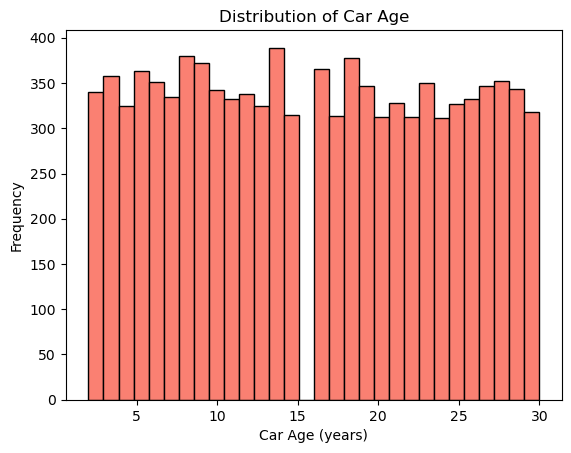

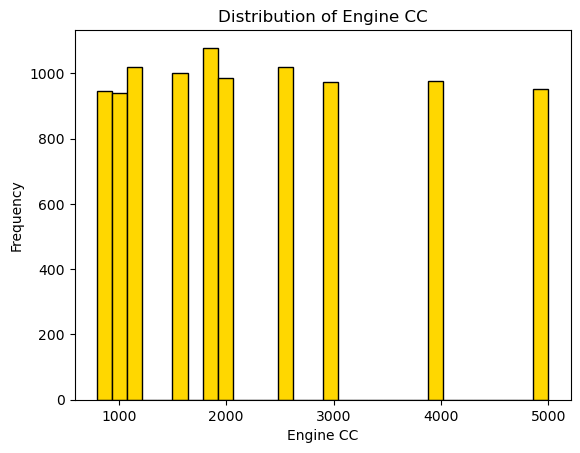

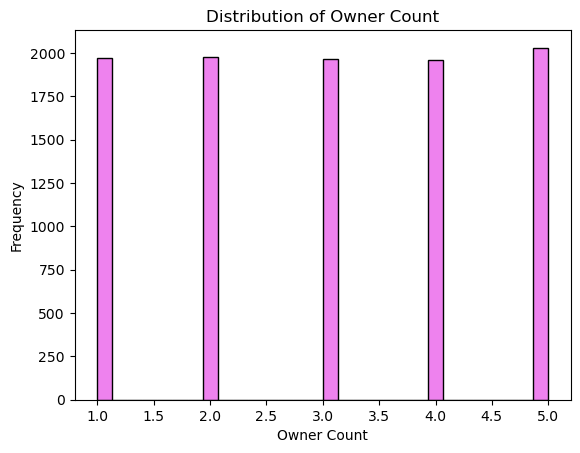

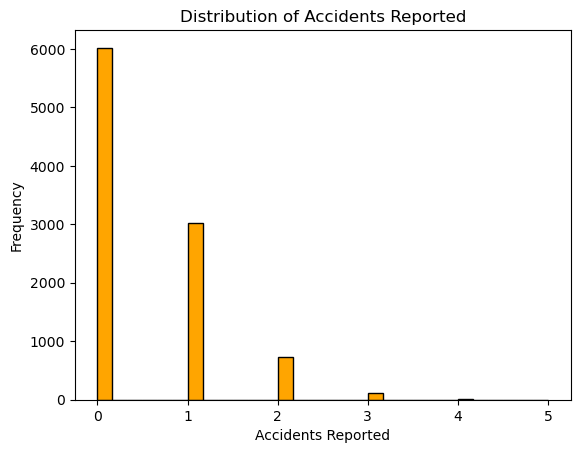

In [31]:
# Price USD Distribution
plt.hist(df_clean['price_usd'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Price (USD)')
plt.show()

# Mileage kmpl Distribution
plt.hist(df_clean['mileage_kmpl'], bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Mileage (kmpl)')
plt.ylabel('Frequency')
plt.title('Distribution of Mileage (kmpl)')
plt.show()

# Car Age Distribution
plt.hist(df_clean['car_age'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Car Age (years)')
plt.ylabel('Frequency')
plt.title('Distribution of Car Age')
plt.show()

# Engine CC Distribution
plt.hist(df_clean['engine_cc'], bins=30, color='gold', edgecolor='black')
plt.xlabel('Engine CC')
plt.ylabel('Frequency')
plt.title('Distribution of Engine CC')
plt.show()

# Owner Count Distribution
plt.hist(df_clean['owner_count'], bins=30, color='violet', edgecolor='black')
plt.xlabel('Owner Count')
plt.ylabel('Frequency')
plt.title('Distribution of Owner Count')
plt.show()

# Accidents Reported Distribution
plt.hist(df_clean['accidents_reported'], bins=30, color='orange', edgecolor='black')
plt.xlabel('Accidents Reported')
plt.ylabel('Frequency')
plt.title('Distribution of Accidents Reported')
plt.show()

Bar plots for categorical features


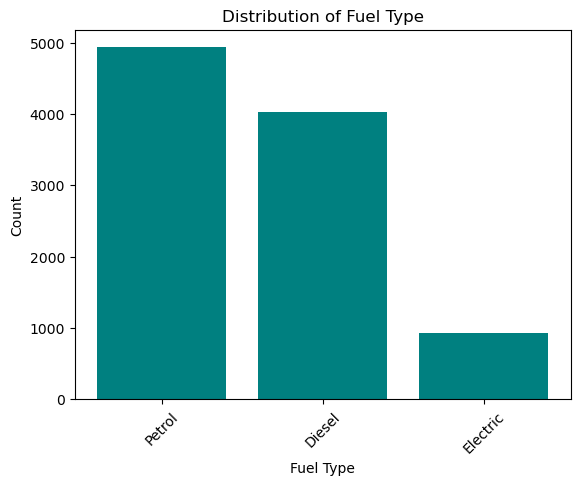

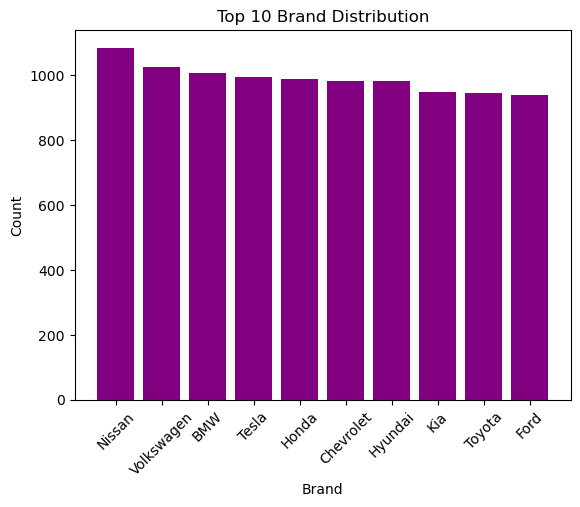

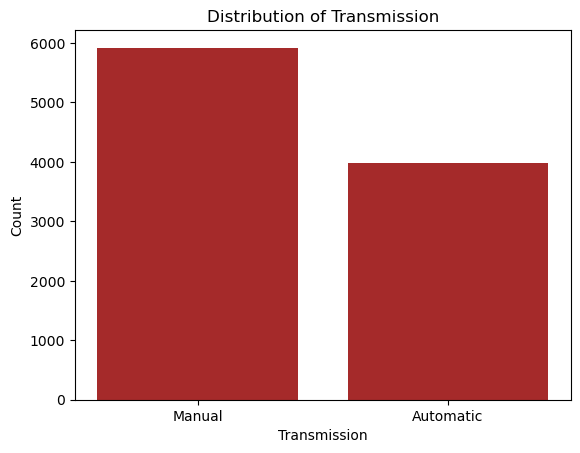

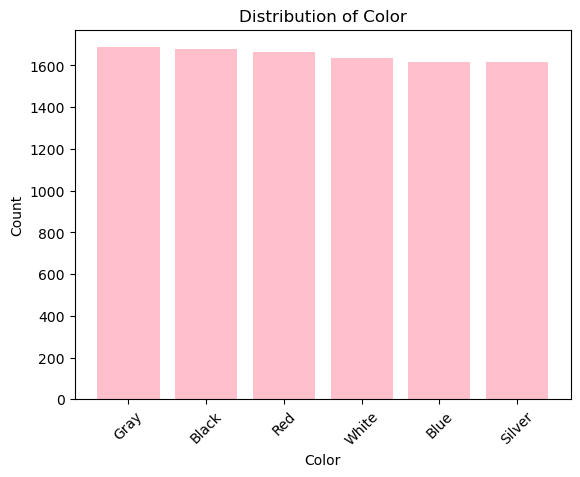

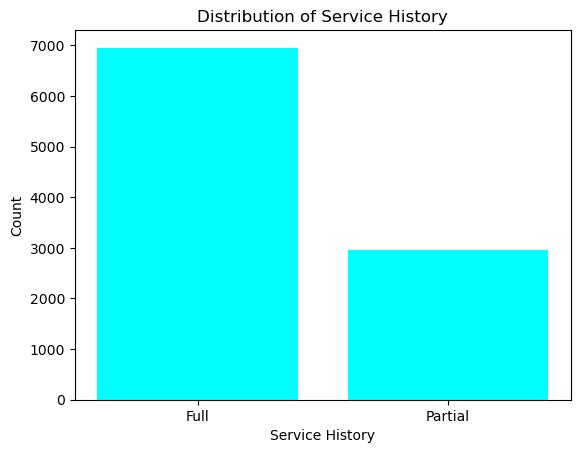

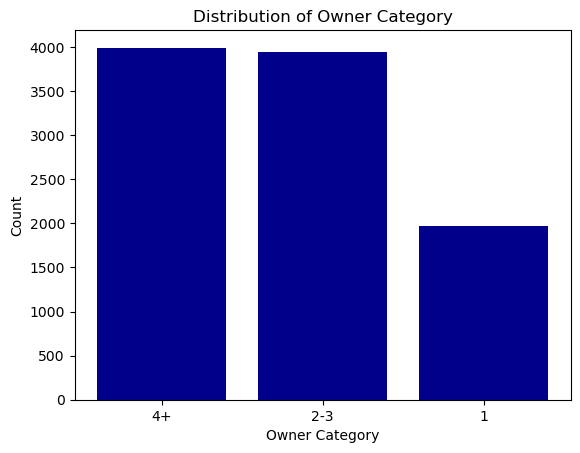

In [33]:
# Fuel Type Distribution
fuel_counts = df_clean['fuel_type'].value_counts()
plt.bar(fuel_counts.index, fuel_counts.values, color='teal')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.title('Distribution of Fuel Type')
plt.xticks(rotation=45)
plt.show()

# Brand Distribution (Top 10)
brand_counts = df_clean['brand'].value_counts().head(10)
plt.bar(brand_counts.index, brand_counts.values, color='purple')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Top 10 Brand Distribution')
plt.xticks(rotation=45)
plt.show()

# Transmission Distribution
trans_counts = df_clean['transmission'].value_counts()
plt.bar(trans_counts.index, trans_counts.values, color='brown')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.title('Distribution of Transmission')
plt.show()

# Color Distribution
color_counts = df_clean['color'].value_counts()
plt.bar(color_counts.index, color_counts.values, color='pink')
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Distribution of Color')
plt.xticks(rotation=45)
plt.show()

# Service History Distribution
service_counts = df_clean['service_history'].value_counts()
plt.bar(service_counts.index, service_counts.values, color='cyan')
plt.xlabel('Service History')
plt.ylabel('Count')
plt.title('Distribution of Service History')
plt.show()

# Owner Category Distribution
owner_counts = df_clean['owner_category'].value_counts()
plt.bar(owner_counts.index, owner_counts.values, color='darkblue')
plt.xlabel('Owner Category')
plt.ylabel('Count')
plt.title('Distribution of Owner Category')
plt.show()

Boxplots for outlier detection

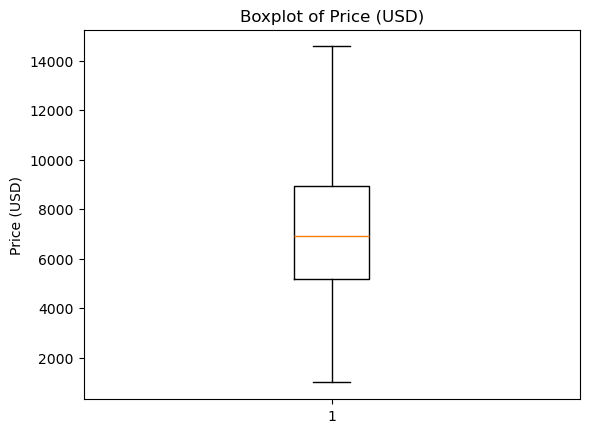

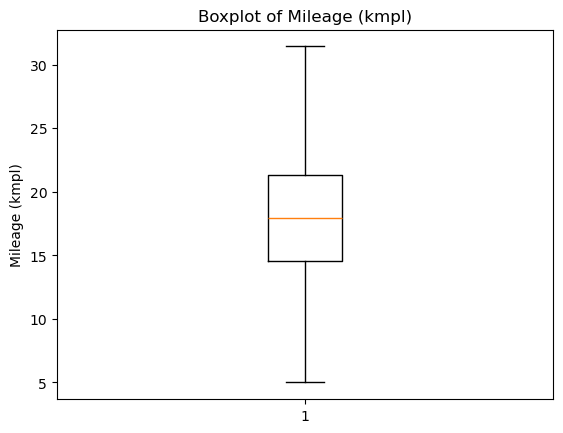

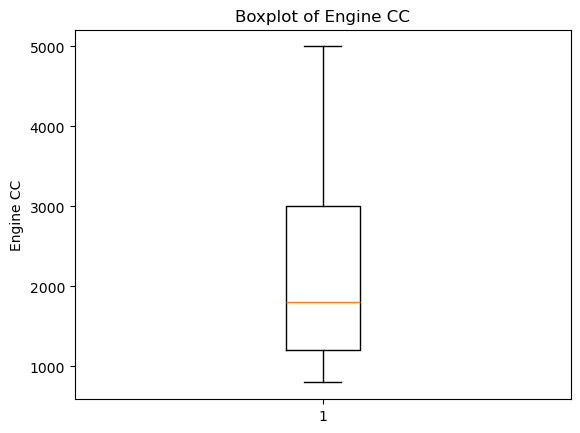

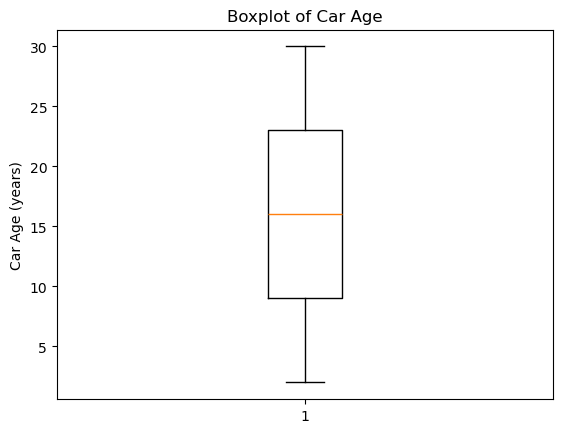

In [35]:
# Price USD Boxplot
plt.boxplot(df_clean['price_usd'])
plt.ylabel('Price (USD)')
plt.title('Boxplot of Price (USD)')
plt.show()

# Mileage kmpl Boxplot
plt.boxplot(df_clean['mileage_kmpl'])
plt.ylabel('Mileage (kmpl)')
plt.title('Boxplot of Mileage (kmpl)')
plt.show()

# Engine CC Boxplot
plt.boxplot(df_clean['engine_cc'])
plt.ylabel('Engine CC')
plt.title('Boxplot of Engine CC')
plt.show()

# Car Age Boxplot
plt.boxplot(df_clean['car_age'])
plt.ylabel('Car Age (years)')
plt.title('Boxplot of Car Age')
plt.show()

### B. Bivariate Analysis

Scatter plots

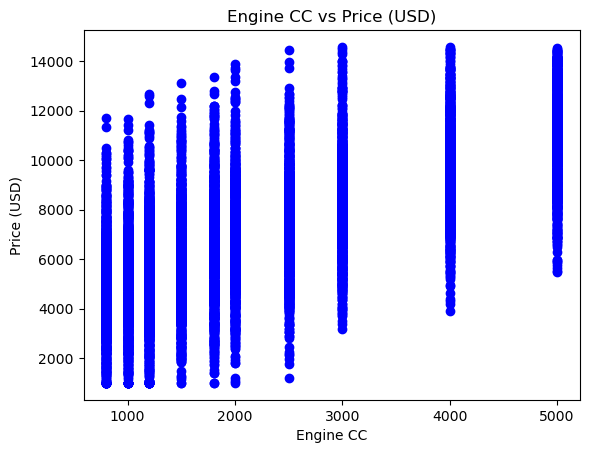

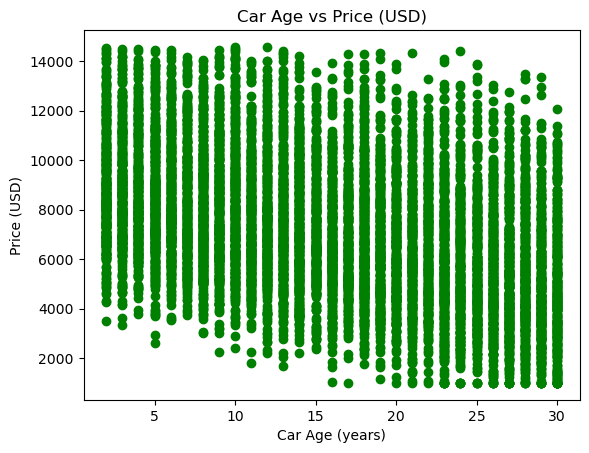

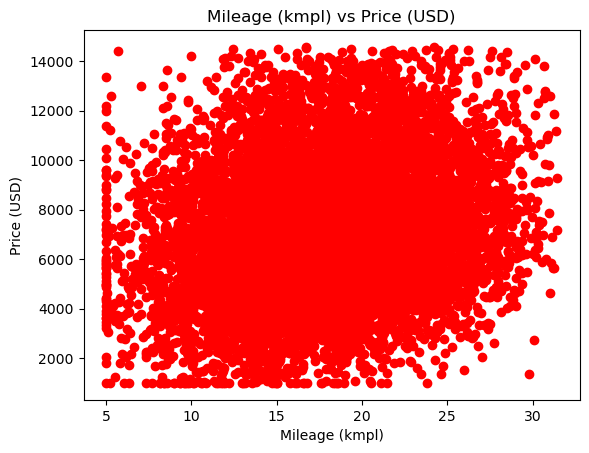

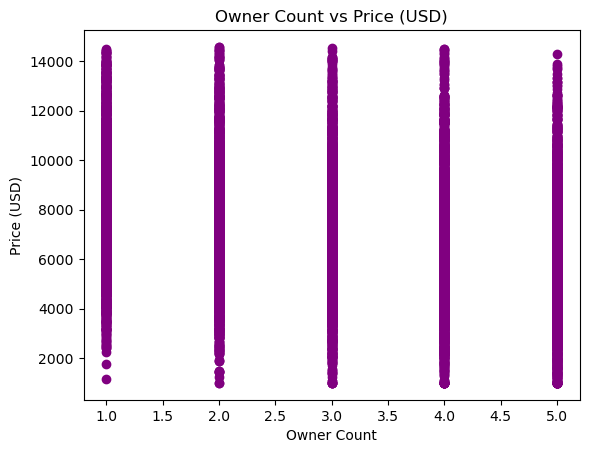

In [50]:
# Engine CC vs Price USD
plt.scatter(df_clean['engine_cc'], df_clean['price_usd'], color='blue')
plt.xlabel('Engine CC')
plt.ylabel('Price (USD)')
plt.title('Engine CC vs Price (USD)')
plt.show()

# Car Age vs Price USD
plt.scatter(df_clean['car_age'], df_clean['price_usd'], color='green')
plt.xlabel('Car Age (years)')
plt.ylabel('Price (USD)')
plt.title('Car Age vs Price (USD)')
plt.show()

# Mileage kmpl vs Price USD
plt.scatter(df_clean['mileage_kmpl'], df_clean['price_usd'], color='red')
plt.xlabel('Mileage (kmpl)')
plt.ylabel('Price (USD)')
plt.title('Mileage (kmpl) vs Price (USD)')
plt.show()

# Owner Count vs Price USD
plt.scatter(df_clean['owner_count'], df_clean['price_usd'], color='purple')
plt.xlabel('Owner Count')
plt.ylabel('Price (USD)')
plt.title('Owner Count vs Price (USD)')
plt.show()

Boxplots - price by categorical features

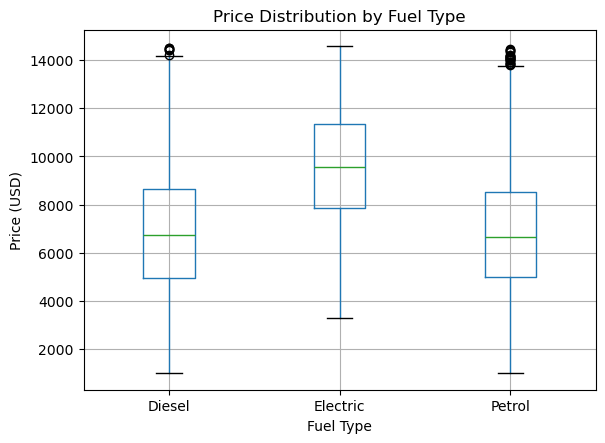

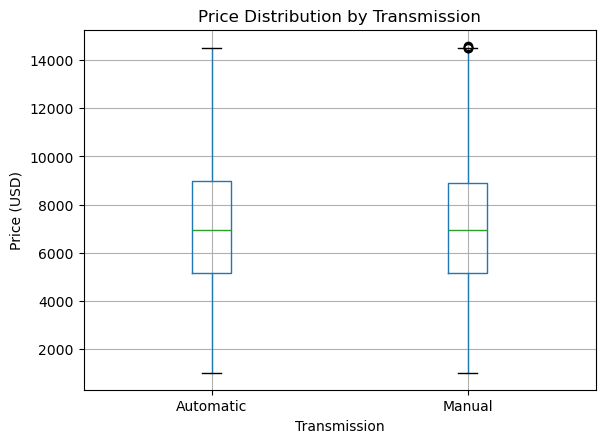

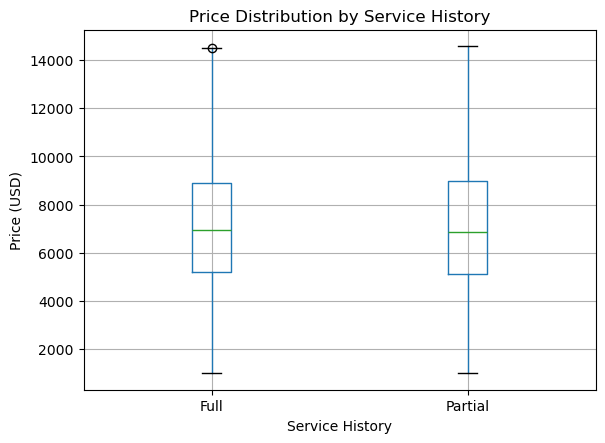

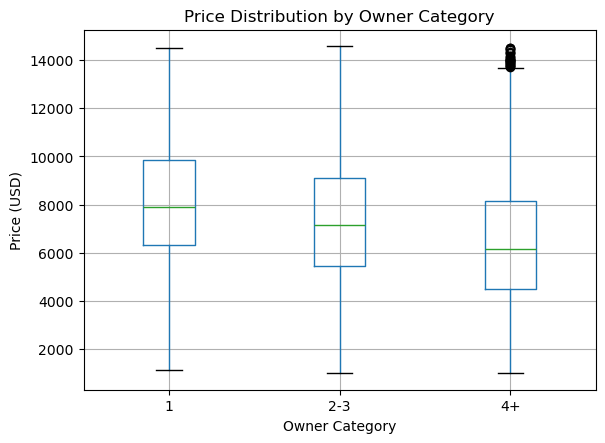

In [51]:
# Price by Fuel Type
df_clean.boxplot(column='price_usd', by='fuel_type')
plt.xlabel('Fuel Type')
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Fuel Type')
plt.suptitle('')  # Remove automatic title
plt.show()

# Price by Transmission
df_clean.boxplot(column='price_usd', by='transmission')
plt.xlabel('Transmission')
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Transmission')
plt.suptitle('')
plt.show()

# Price by Service History
df_clean.boxplot(column='price_usd', by='service_history')
plt.xlabel('Service History')
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Service History')
plt.suptitle('')
plt.show()

# Price by Owner Category
df_clean.boxplot(column='price_usd', by='owner_category')
plt.xlabel('Owner Category')
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Owner Category')
plt.suptitle('')
plt.show()


Price by brand (between 10 brands)

C:\Users\milan\AppData\Local\Temp\ipykernel_28608\3285944650.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='brand', y='price_usd', palette='pastel')


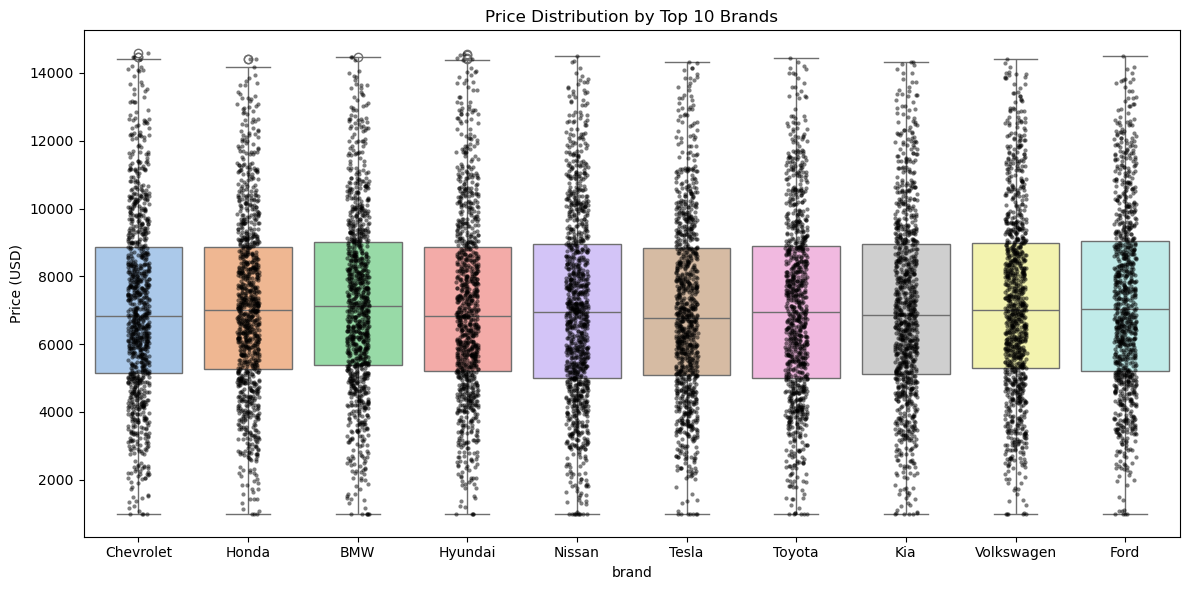

In [75]:
plt.figure(figsize=(12, 6))
# Boxplot
sns.boxplot(data=df_clean, x='brand', y='price_usd', palette='pastel')

# Stripplot overlaid
sns.stripplot(data=df_clean, x='brand', y='price_usd', color='black', size=3, alpha=0.5)
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Top 10 Brands')
plt.tight_layout()
plt.show()

### C. Multivariate Analysis

Correlation heatmap

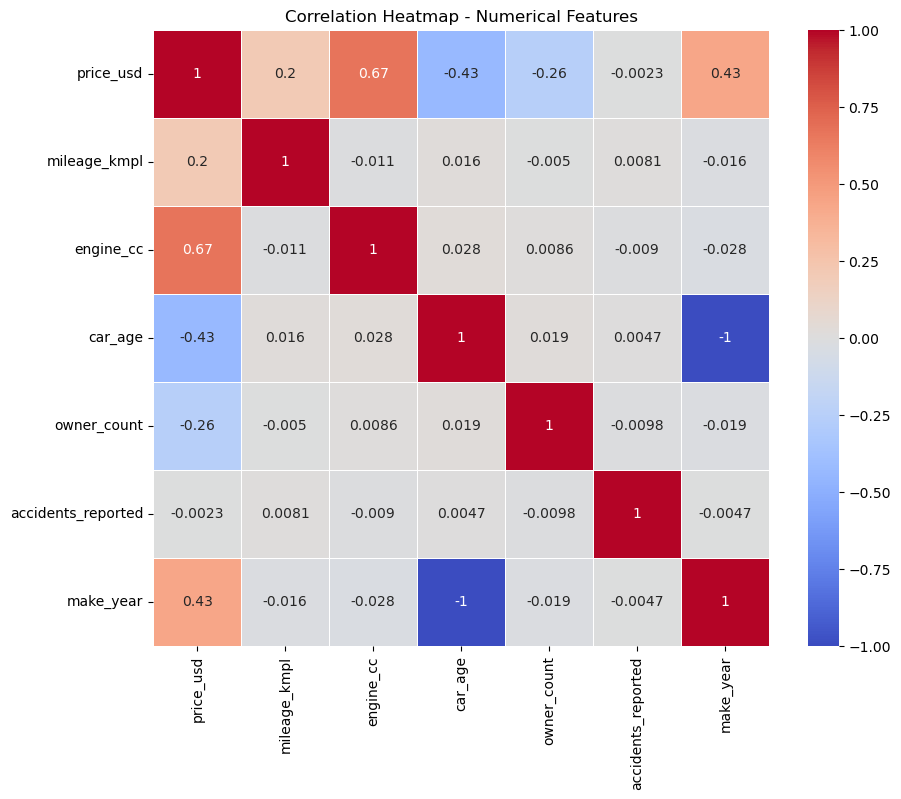

In [76]:
numerical_features_for_corr = ['price_usd', 'mileage_kmpl', 'engine_cc', 'car_age', 
                             'owner_count', 'accidents_reported', 'make_year']
correlation_matrix = df_clean[numerical_features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap - Numerical Features')
plt.show()

Pairplot for key variables


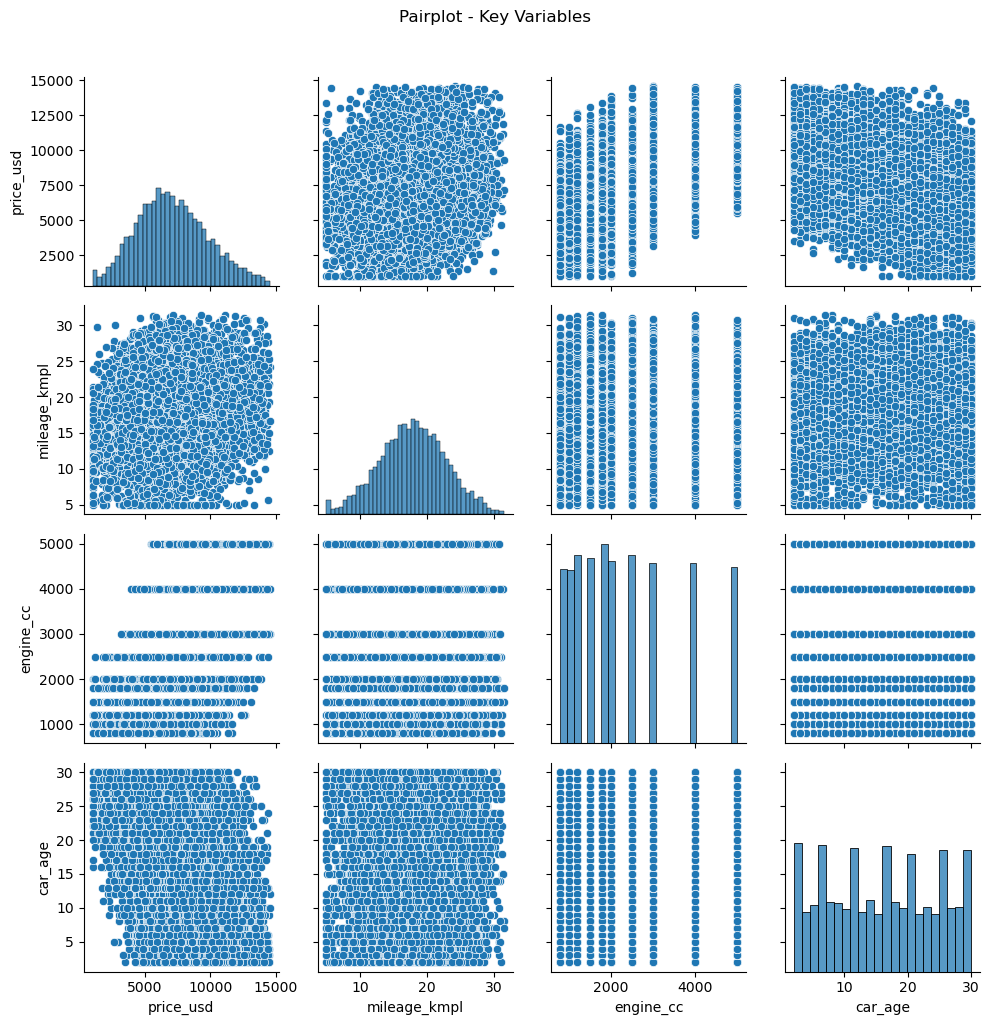

In [80]:
# Pairplot for key variables
key_variables = ['price_usd', 'mileage_kmpl', 'engine_cc', 'car_age']
df_sample = df_clean[key_variables]

sns.pairplot(df_sample)
plt.suptitle('Pairplot - Key Variables', y=1.02)
plt.tight_layout()
plt.show()

Stacked bar chart - brand vs fuel_type vs insurance_valid

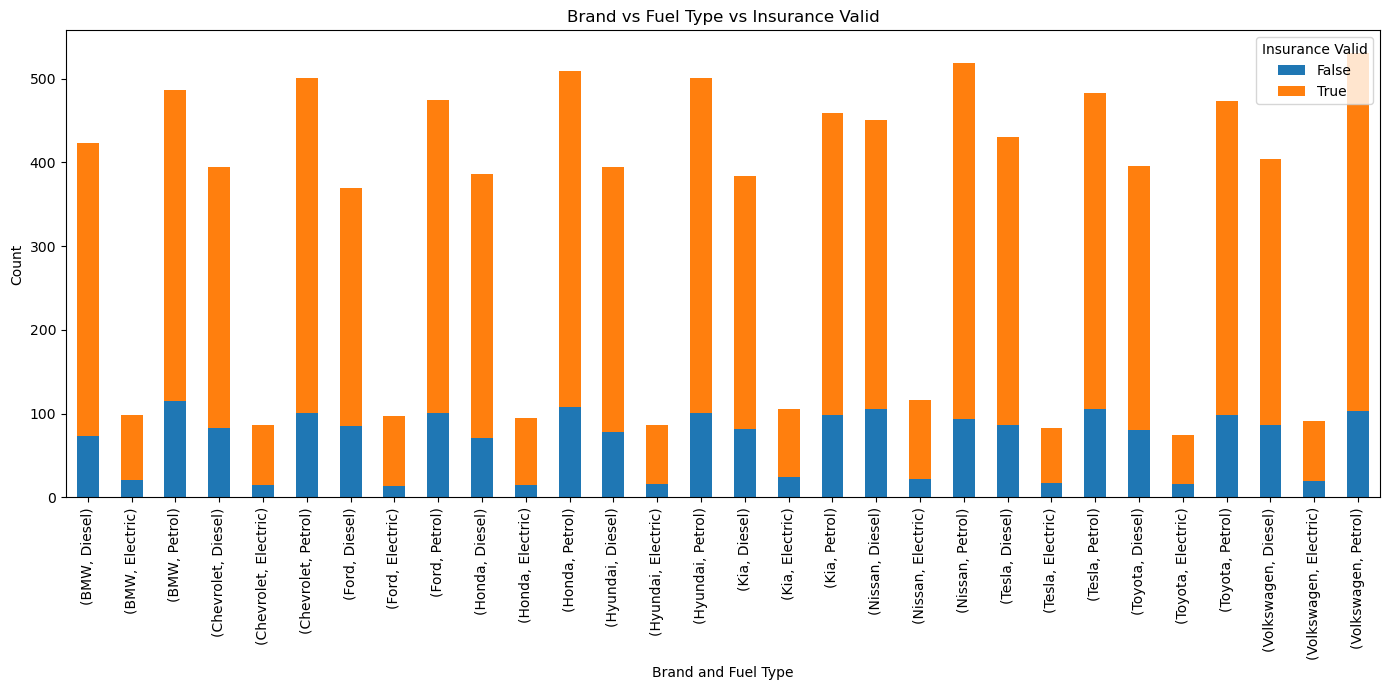

In [87]:
crosstab = pd.crosstab([df_clean['brand'], df_clean['fuel_type']], 
                       df_clean['insurance_valid'])

# Plotting
ax = crosstab.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.xlabel('Brand and Fuel Type')
plt.ylabel('Count')
plt.title('Brand vs Fuel Type vs Insurance Valid')
plt.legend(title='Insurance Valid')
plt.tight_layout()
plt.show()

### D. Target Variable Distribution

Price distribution

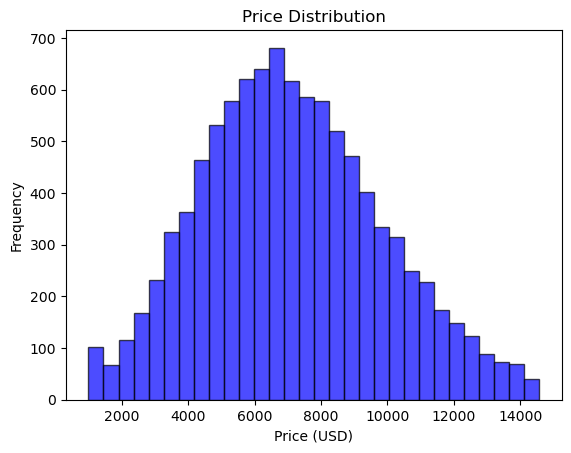

In [92]:
plt.hist(df_clean['price_usd'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()


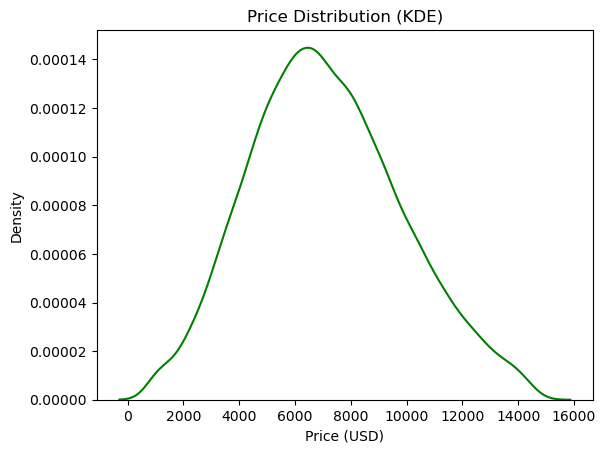

In [89]:
# KDE plot
sns.kdeplot(data=df_clean, x='price_usd', color='green')
plt.xlabel('Price (USD)')
plt.title('Price Distribution (KDE)')
plt.show()

In [96]:
print(f"Skewness: {df_clean['price_usd'].skew():.2f}") # slight right skew

Skewness: 0.26


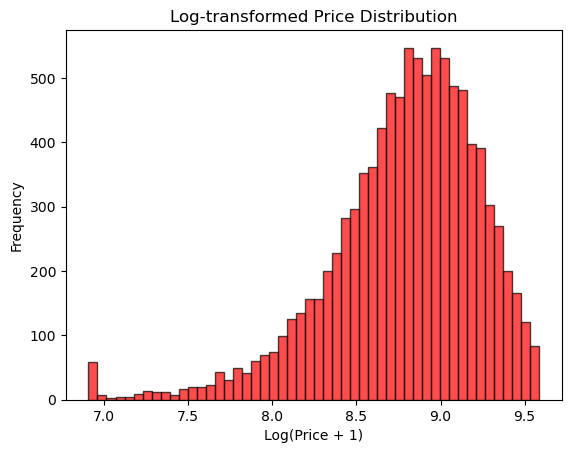

In [95]:
# Log-transformed distribution
log_price = np.log1p(df_clean['price_usd'])
plt.hist(log_price, bins=50, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.title('Log-transformed Price Distribution')
plt.show()

### E. Categorical Value Counts

High-cardinality categorical features

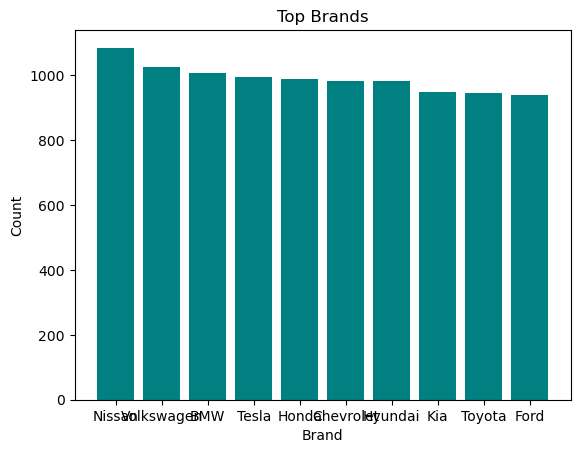

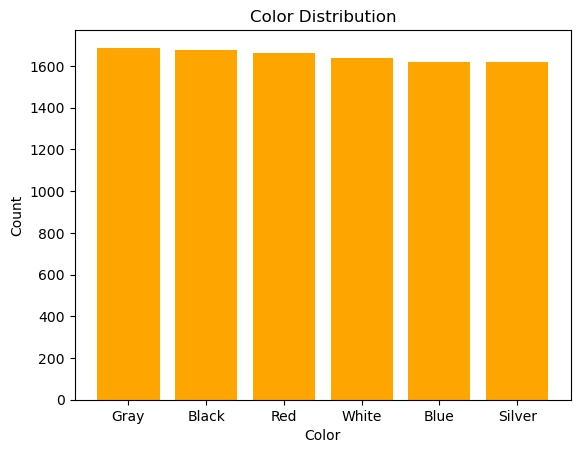

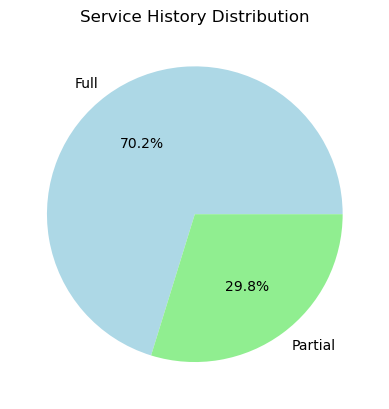

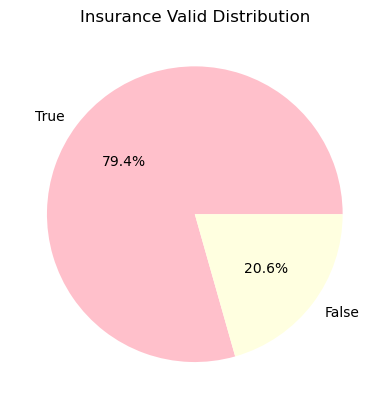

In [99]:
brand_counts = df_clean['brand'].value_counts()
plt.bar(brand_counts.index, brand_counts.values, color='teal')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Top Brands')
plt.show()

# Color counts
color_counts = df_clean['color'].value_counts()
plt.bar(color_counts.index, color_counts.values, color='orange')
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Color Distribution')
plt.show()

# Service history
service_counts = df_clean['service_history'].value_counts()
plt.pie(service_counts.values, labels=service_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightgreen'])
plt.title('Service History Distribution')
plt.show()

# Insurance valid
insurance_counts = df_clean['insurance_valid'].value_counts()
plt.pie(insurance_counts.values, labels=insurance_counts.index, autopct='%1.1f%%', 
        colors=['pink', 'lightyellow'])
plt.title('Insurance Valid Distribution')
plt.show()

## Modeling

After Encoding

In [24]:
df_clean.head()

,make_year,mileage_kmpl,engine_cc,owner_count,price_usd,transmission,service_history,accidents_reported,insurance_valid,car_age,...,brand_Tesla,brand_Toyota,brand_Volkswagen,color_Blue,color_Gray,color_Red,color_Silver,color_White,owner_category_2-3,owner_category_4+
0,2001,8.17,4000,4,8587.64,0,1,0,0,24,...,False,False,False,False,False,False,False,True,False,True
1,2014,17.59,1500,4,5943.50,0,1,0,1,11,...,False,False,False,False,False,False,False,False,False,True
2,2023,18.09,2500,5,9273.58,1,1,1,1,2,...,False,False,False,False,False,False,False,False,False,True
3,2009,11.28,800,1,6836.24,0,1,0,1,16,...,False,False,False,True,False,False,False,False,False,False
4,2005,12.23,1000,2,4625.79,1,1,0,1,20,...,False,False,False,False,False,True,False,False,True,False


### Random Forest Model


In [30]:
X = df_clean.drop('price_usd', axis=1)  # Features
y = df_clean['price_usd']  # Target variable

# (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [ 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # num of trials
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1 # CPU cores
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [36]:
# Best model
best_rf = random_search.best_estimator_

# Predict and evaluate
y_pred_best_rf = best_rf.predict(X_test)

In [37]:
best_rf_mae = mean_absolute_error(y_test, y_pred_best_rf)
best_rf_mse = mean_squared_error(y_test, y_pred_best_rf)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_r2 = r2_score(y_test, y_pred_best_rf)

# Print performance
print("Tuned Random Forest Performance:")
print(f"- MAE: ${best_rf_mae:.2f}")
print(f"- MSE: ${best_rf_mse:.2f}")
print(f"- RMSE: ${best_rf_rmse:.2f}")
print(f"- R²: {best_rf_r2:.4f}")

Tuned Random Forest Performance:
- MAE: $904.65
- MSE: $1271311.24
- RMSE: $1127.52
- R²: 0.8326


C:\Users\milan\AppData\Local\Temp\ipykernel_33076\47834387.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_feature_importances, palette='viridis')


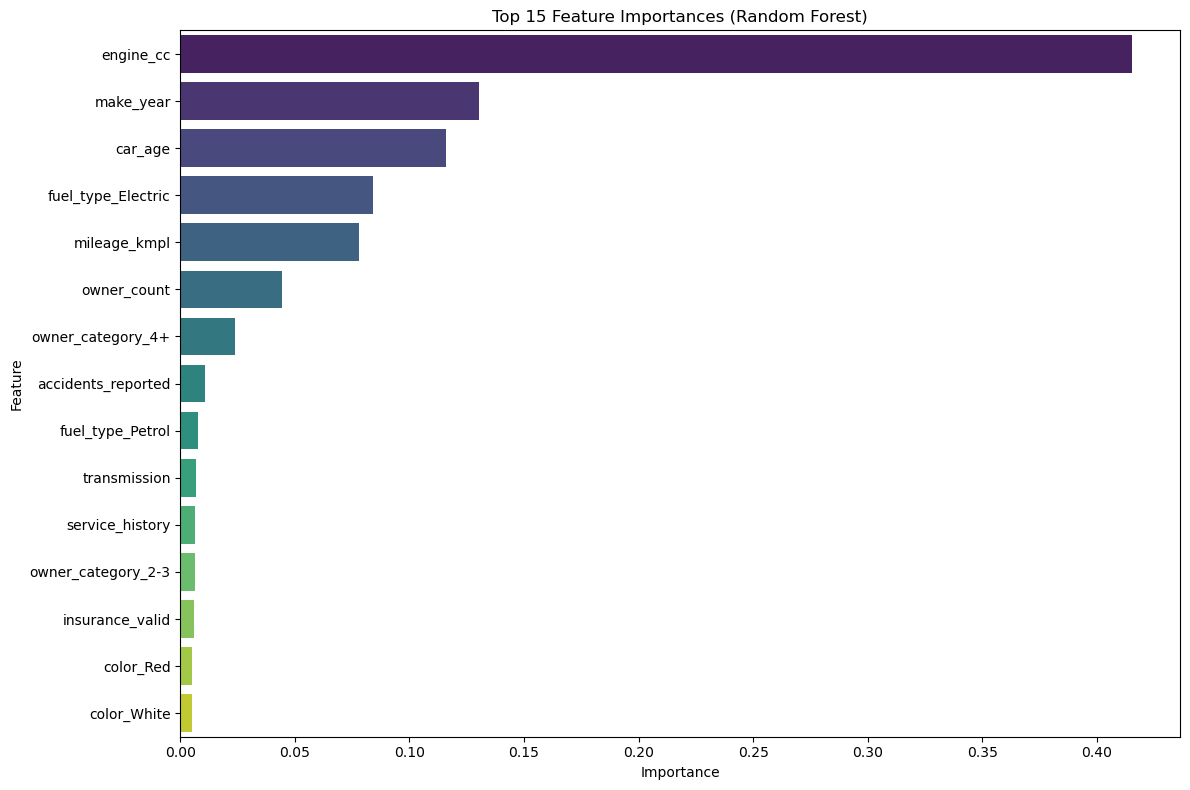

In [50]:
# Feature importance analysis
rf_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importances, palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

### XGBoost Model

In [55]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 10, 20, 30], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],  # L1
    'reg_lambda': [1, 1.5, 2]  # L2
}

# Initialize XGBoost model
xgb = XGBRegressor(objective='reg:squarederror',tree_method='hist',random_state=42, n_jobs=-1)


# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,  # number of trials
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [56]:
# Best model
best_xgb = random_search.best_estimator_

# Predict and evaluate
y_pred_best_xgb = best_xgb.predict(X_test)

In [57]:
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_mae = mean_absolute_error(y_test, y_pred_best_xgb)
best_xgb_mse = mean_squared_error(y_test, y_pred_best_xgb)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_r2 = r2_score(y_test, y_pred_best_xgb)

# Print performance
print("Tuned XGBoost Performance:")
print(f"- MAE: ${best_xgb_mae:.2f}")
print(f"- MSE: ${best_xgb_mse:.2f}")
print(f"- RMSE: ${best_xgb_rmse:.2f}")
print(f"- R²: {best_xgb_r2:.4f}")

Tuned XGBoost Performance:
- MAE: $804.42
- MSE: $1015797.34
- RMSE: $1007.87
- R²: 0.8662


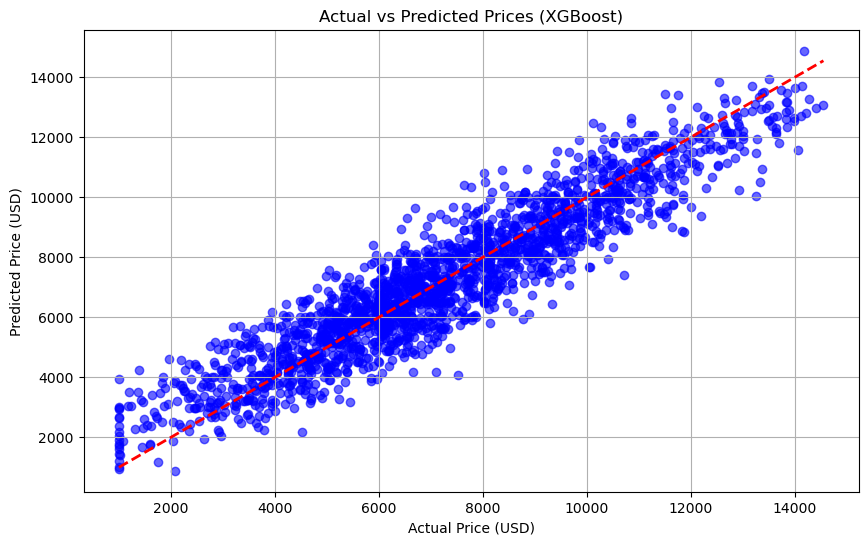

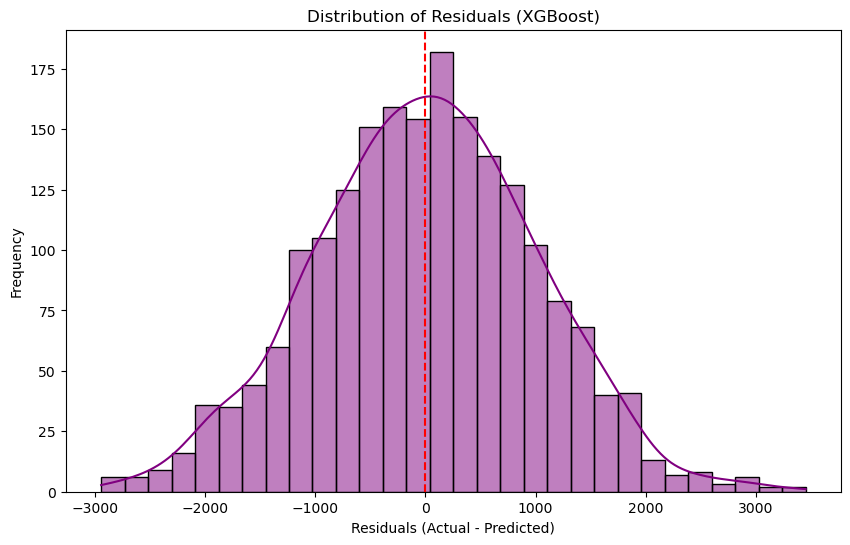

In [61]:
# Actual vs Predicted plot for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_xgb, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.grid(True)
plt.show()

# Residual plot for XGBoost
residuals = y_test - y_pred_best_xgb
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (XGBoost)')
plt.show()

Model Comparison

In [62]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [best_rf_mae, best_xgb_mae],
    'RMSE': [best_rf_rmse, best_xgb_rmse],
    'R²': [best_rf_r2, best_xgb_r2]
})
print(model_comparison)

           Model         MAE         RMSE        R²
0  Random Forest  904.651150  1127.524387  0.832558
1        XGBoost  804.421969  1007.867717  0.866211


Saving the Models

In [63]:
import joblib

# Save the trained XGBoost model
joblib.dump(best_xgb, 'car_price_xgboost_model.pkl')

['car_price_xgboost_model.pkl']

In [64]:
import joblib

# Save the trained RandomForest model
joblib.dump(best_rf, 'car_price_rf_model.pkl')

['car_price_rf_model.pkl']